# GROUP MEMBER NAMES AND UID


**Member 1**
*   **Name**: Jim Solomon
*   **UID**: 005371849

**Member 2**
*   **Name**: Yujie Wang
*   **UID**: 406077623

**Member 3**
*   **Name**: Zihan Wang
*   **UID**: 306077614

**Member 4**
*   **Name**: Zilin Zeng
*   **UID**: 006073844




In [4]:
!pip install torchinfo

In [5]:
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter   # print to tensorboard
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy
from sklearn import metrics
from torchinfo import summary
from tqdm import tqdm
from scipy import signal
import librosa
import random
import time
from google.colab import drive
drive.mount('/content/drive')
# change to your folder directory
# %cd "/content/drive/MyDrive/Colab Notebooks/Classes/ECE C247/Project/project"
%cd "/content/drive/MyDrive/EE247_FinalProject/project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EE247_FinalProject/project


In [6]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

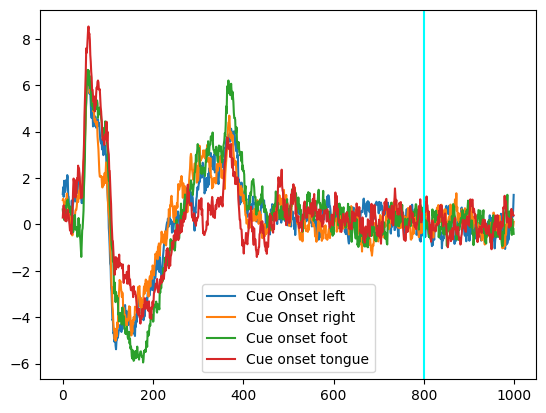

In [7]:
## Visualizing the data


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=800, label='line at t=800',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])



In [8]:
def train_data_prep(X,y,sub_sample,average,noise,time_sel):
    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_sel]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))


    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                      (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    return total_X,total_y



def data_prep_stft(data_x):
    fs = 250
    nperseg = 100
    _, _, X_stft = signal.stft(data_x, fs=fs, nperseg=nperseg, nfft=nperseg)  # keep the same frequency bins, pad on time
    return np.abs(X_stft)


def data_lpc(data_x):
    X_lpc = librosa.lpc(data_x, order=15)
    return X_lpc


def data_cep(data_x):
    X_mfcc = librosa.feature.mfcc(y=data_x, sr=250, n_fft=50, n_mfcc=39)
    X_cep = np.max(X_mfcc, axis=-1)
    return X_cep


def val_test_data_prep(X,time_sel):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_sel]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_aug = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    total_X = X_aug

    return total_X


In [9]:
def data_loader(X_train_valid, y_train_valid, model_choice="EEG", time_sel=800, z_norm=False):
    num_data = X_train_valid.shape[0]
    data_ls = np.arange(num_data)
    np.random.shuffle(data_ls)

    train_ls = data_ls[num_data//5::]
    train_label = y_train_valid[train_ls]
    train_data = X_train_valid[train_ls]
    train_data_aug, train_label_aug = train_data_prep(train_data, train_label,2,2,True,time_sel)

    if model_choice == "CNN":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], train_data_aug.shape[1], train_data_aug.shape[2], 1)

    if model_choice == "EEG":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], 1, train_data_aug.shape[1], train_data_aug.shape[2])

    if model_choice == "STFT":
        train_data_stft_raw = data_prep_stft(train_data)    # STFT on untruncated data
        train_data_stft_aug = data_prep_stft(train_data_aug)    # STFT on filtered data
        train_data_stft_aug_zp = np.zeros([train_data_stft_aug.shape[0], train_data_stft_aug.shape[1], train_data_stft_aug.shape[2], train_data_stft_raw.shape[-1]])
        train_data_stft_aug_zp[:,:,:,0:train_data_stft_aug.shape[-1]] = train_data_stft_aug
        train_data_aug = np.concatenate((train_data_stft_raw, train_data_stft_aug_zp), axis=0)
        train_label_aug = np.concatenate((train_label, train_label_aug), axis=0)

    if model_choice == "Speech":
        train_data_lpc= data_lpc(train_data)
        train_data_cep = data_cep(train_data)
        train_data_aug_lpc = data_lpc(train_data_aug)
        train_data_aug_cep = data_cep(train_data_aug)
        train_data_speech = np.concatenate((train_data_lpc,train_data_cep), axis=-1)
        train_data_aug_speech= np.concatenate((train_data_aug_lpc,train_data_aug_cep), axis=-1)
        train_data_aug = np.concatenate((train_data_speech, train_data_aug_speech), axis=0)
        train_label_aug = np.concatenate((train_label, train_label_aug), axis=0)
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], 1, train_data_aug.shape[1], train_data_aug.shape[2])


    val_ls = data_ls[0:num_data//5]
    val_label = y_train_valid[val_ls]
    val_data = X_train_valid[val_ls]
    val_data_aug = val_test_data_prep(val_data, time_sel)

    if model_choice == "CNN":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], 1)

    if model_choice == "EEG":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], 1, val_data_aug.shape[1], val_data_aug.shape[2])

    if model_choice == "STFT":
        val_data_aug = data_prep_stft(val_data_aug)
        val_stft_aug_zp = np.zeros([val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], train_data_stft_raw.shape[-1]])
        val_stft_aug_zp[:,:,:,0:val_data_aug.shape[-1]] = val_data_aug
        val_data_aug = val_stft_aug_zp

    if model_choice == "Speech":
        val_data_aug_lpc = data_lpc(val_data_aug)
        val_data_aug_cep = data_cep(val_data_aug)
        val_data_aug = np.concatenate((val_data_aug_lpc,val_data_aug_cep), axis=-1)
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], 1, val_data_aug.shape[1], val_data_aug.shape[2])


    print("My training data: ", train_data_aug.shape)
    print("My training label: ", train_label_aug.shape)
    print()
    print("My val data: ", val_data_aug.shape)
    print("My val label: ", val_label.shape)
    print()

    return torch.from_numpy(train_data_aug), torch.from_numpy(train_label_aug), torch.from_numpy(val_data_aug), torch.from_numpy(val_label)


def batch_data(train_num, batch_size):
    data_ls = np.arange(train_num)
    np.random.shuffle(data_ls)  # shuffle augmented training data
    split_ls = np.repeat(batch_size, train_num//batch_size)

    if train_num%batch_size != 0:
        split_ls = np.hstack([split_ls, train_num%batch_size])

    split_ls = np.cumsum(split_ls)
    mini_batch_ls = np.split(data_ls, split_ls)
    del mini_batch_ls[-1]

    return mini_batch_ls

In [10]:
np.random.seed(247)
x_train_CNN, y_train_CNN, x_valid_CNN, y_valid_CNN= data_loader(X_train_valid, y_train_valid, model_choice="CNN")
x_train_EEG, y_train_EEG, x_valid_EEG, y_valid_EEG = data_loader(X_train_valid, y_train_valid, model_choice="EEG")

My training data:  (6768, 22, 400, 1)
My training label:  (6768,)

My val data:  (423, 22, 400, 1)
My val label:  (423,)

My training data:  (6768, 1, 22, 400)
My training label:  (6768,)

My val data:  (423, 1, 22, 400)
My val label:  (423,)



In [11]:
###################################################################################
## Plotting Figures ###############################################################
###################################################################################
def make_figure(training_acc, validation_acc, name="fig"):
    x_axis = np.arange(0, len(training_acc))
    plt.plot(x_axis, training_acc, color='r', label='training')
    plt.plot(x_axis, validation_acc, color='g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(name + '.png')
    plt.show()

In [12]:
###################################################################################
## Training Function ##############################################################
###################################################################################
def train_model(data, optimizer, criterion, model, batch_size = 64, epochs = 30, anneal_=False, scheduler_coeff = 10, T_mult=1):
    # Getting the appropriate cuda device
    # Initialize for each model setup
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # Getting our data for training and validation
    x_train = data['x_train'].to(device, dtype = torch.float)
    y_train = data['y_train'].to(device, dtype = torch.long)
    x_valid = data['x_valid'].to(device, dtype=torch.float)
    y_valid = data['y_valid'].to(device, dtype=torch.long)
    num_training_data = x_train.shape[0]
    num_val_data = x_valid.shape[0]
    num_iterations = len(batch_data(num_training_data, batch_size))

    if anneal_ == True:
        print("Annealing")
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iterations*scheduler_coeff)

    # Placing our model parameters in the GPU
    print("Current Model: ", model)

    # Initializing variables for tracking our loss and accuracies
    running_loss = 0
    training_acc = []
    validation_acc = []

    np.random.seed(247)
    torch.manual_seed(147)
    # Training loop
    for epoch in tqdm(range(epochs)):
        batch_list = batch_data(num_training_data, batch_size)
        # Preparing the model for training
        model.train()

        print("Epoch: ", epoch + 1)
        running_loss = 0.0

        for iter_ in range(num_iterations):
            train_batch = x_train[batch_list[iter_]].to(device, dtype=torch.float)
            label_batch = y_train[batch_list[iter_]].to(device, dtype=torch.long)
            model.zero_grad()
            outputs = model(train_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            if anneal_ == True:
                scheduler.step()
                # print(scheduler.get_last_lr())

            running_loss += loss.item()

            if (iter_+1) % (num_iterations//4) == 0:
                print('[{}, {}] loss: {:.3f}'.format(epoch + 1, iter_ + 1, running_loss / (num_iterations//4)))
                running_loss = 0.0

        # Validation


        with torch.no_grad():
            model.eval()      # set to testing mode for BN and Dropout
            print("Check: ", x_valid.shape)
            val_out = model(x_valid)     # no Batch in testing mode

            train_predict = torch.argmax(outputs, dim = 1)
            train_acc = torch.mean(torch.eq(label_batch, train_predict).float(), dtype = torch.float)
            training_acc.append(train_acc.cpu().numpy())

            val_predict = torch.argmax(val_out, dim=1)
            val_acc  = torch.mean(torch.eq(y_valid, val_predict).float(), dtype = torch.float)
            validation_acc.append(val_acc.cpu().numpy())
            print('Validation Accuracy: {}'.format(val_acc, dtype = torch.float))


        if (anneal_ == True) and ((epoch+1) % scheduler_coeff == 0):
            print('Reset scheduler after finishing epoch: ', epoch+1)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_mult=T_mult, T_0=num_iterations*scheduler_coeff)

    print("Finish Training")
    return np.array(training_acc), np.array(validation_acc)


In [13]:
###################################################################################
## Testing Function ##############################################################
###################################################################################
def test_model(model, cae, model_choice="CNN", X_test=X_test, y_test=y_test,time_sel=800):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # check test acc
    x_test = val_test_data_prep(X_test,time_sel)

    if model_choice == "STFT":
        x_test = data_prep_stft(x_test)
        x_test_zp = np.zeros([x_test.shape[0], x_test.shape[1], x_test.shape[2], x_train_STFT.shape[-1]])
        x_test_zp[:,:,:,0:x_test.shape[-1]] = x_test
        x_test = x_test_zp

    if model_choice == "Speech":
        x_test_lpc = data_lpc(x_test)
        x_test_cep = data_cep(x_test)
        x_test = np.concatenate((x_test_lpc,x_test_cep), axis=-1)


    if type(x_test)!=torch.Tensor:
        x_test = torch.from_numpy(x_test).to(device, dtype=torch.float)

        if model_choice == "CNN":
            x_test = x_test.unsqueeze(-1)

        if model_choice == "EEG" or model_choice == "Speech":
            x_test = x_test.unsqueeze(1)


    if type(y_test)!=torch.Tensor:
        y_test = torch.from_numpy(y_test).to(device, dtype=torch.long)

    x_test = cae.encoder(x_test.to(device, dtype = torch.float))


    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()     # set to testing mod for BN and Dropout
        test_out = model(x_test)
        test_predict = torch.argmax(test_out, dim=1)

    num_test = x_test.shape[0]
    test_acc  = torch.sum((test_predict == y_test)).item()/num_test
    print("Test accuracy for ", "MLP + Autoencoder", "is: ", test_acc)


# **MODEL DEFINITION**





> Here, we define the models used in this experiment. Our models are:
1.  We define our Autoencoder below
2.  We define our MLP below

In [14]:
## Defining the Autoencoder Architecture

class CAE(nn.Module):
  def __init__(self):
    super(CAE, self).__init__()
    self.encoder = nn.Sequential(
			nn.Conv2d(22, 32, kernel_size=3, stride=1, padding=1),
			nn.ELU(),
			nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
			nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
			nn.ELU(),
			nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
		)
    self.decoder = nn.Sequential(
			nn.ConvTranspose2d(8, 32,
							kernel_size=3,
							stride=2,
							padding=1,
							output_padding=1),
			nn.ELU(),
			nn.ConvTranspose2d(32, 22,
							kernel_size=3,
							stride=2,
							padding=1,
							output_padding=1),
			nn.Sigmoid()
		)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    x = torch.mean(x, dim = 3).unsqueeze(-1)
    return x


In [15]:
cae = CAE()
summary(cae, input_size= x_train_CNN.shape)

Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      [6768, 22, 400, 1]        --
├─Sequential: 1-1                        [6768, 8, 100, 1]         --
│    └─Conv2d: 2-1                       [6768, 32, 400, 1]        6,368
│    └─ELU: 2-2                          [6768, 32, 400, 1]        --
│    └─MaxPool2d: 2-3                    [6768, 32, 200, 1]        --
│    └─Conv2d: 2-4                       [6768, 8, 200, 1]         2,312
│    └─ELU: 2-5                          [6768, 8, 200, 1]         --
│    └─MaxPool2d: 2-6                    [6768, 8, 100, 1]         --
├─Sequential: 1-2                        [6768, 22, 400, 4]        --
│    └─ConvTranspose2d: 2-7              [6768, 32, 200, 2]        2,336
│    └─ELU: 2-8                          [6768, 32, 200, 2]        --
│    └─ConvTranspose2d: 2-9              [6768, 22, 400, 4]        6,358
│    └─Sigmoid: 2-10                     [6768, 22, 400, 4]        --
Tot

In [16]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.mlp = nn.Sequential (
        nn.Flatten(),
        nn.Linear(800, 400),
        nn.ReLU(),
        nn.Linear(400, 200),
        nn.ReLU(),
        nn.Linear(200, 100),
        nn.ReLU(),
        nn.Linear(100, 4)
    )
  def forward(self, x):
    out = self.mlp(x)
    return out

In [17]:
mlp = MLP()
summary(mlp, input_size=[64,800])

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 4]                   --
│    └─Flatten: 2-1                      [64, 800]                 --
│    └─Linear: 2-2                       [64, 400]                 320,400
│    └─ReLU: 2-3                         [64, 400]                 --
│    └─Linear: 2-4                       [64, 200]                 80,200
│    └─ReLU: 2-5                         [64, 200]                 --
│    └─Linear: 2-6                       [64, 100]                 20,100
│    └─ReLU: 2-7                         [64, 100]                 --
│    └─Linear: 2-8                       [64, 4]                   404
Total params: 421,104
Trainable params: 421,104
Non-trainable params: 0
Total mult-adds (M): 26.95
Input size (MB): 0.20
Forward/backward pass size (MB): 0.36
Params size (MB): 1.68
Estimated Total Size (MB): 2.

# **Training Our Models**

In [18]:
###################################################################################
## Training the Auto Encoder ######################################################
###################################################################################

def train_encoder(criterion, optimizer, model, x_train, x_valid):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  num_epoch= 60
  batch_size=64
  num_training_data = x_train.shape[0]
  x_valid = x_valid.to(device, dtype=torch.float)
  running_loss = 0

  training_acc = []
  validation_acc = []

  model.train()

  for epoch in range(num_epoch):
      running_loss = 0.0
      num_iterations = 200

      print("Epoch: ", epoch+1)

      for iter_ in range(num_iterations):

          # pick a batch for grad descent
          batch_index = np.random.choice(np.arange(num_training_data), batch_size, replace=False)
          train_batch = x_train[batch_index].to(device, dtype=torch.float)

          # zero the parameter gradients for each step
          model.zero_grad()

          # forward + backward + optimize
          outputs = model(train_batch)
          # outputs_predict = torch.argmax(outputs, dim=1)
          loss = criterion(outputs, train_batch)
          loss.backward()
          optimizer.step()
          # print statistics

          running_loss += loss.cpu().item()
          if iter_ % (100-1) == 0:    # print every 100 iterations
              print('[{}, {}] loss: {:.3f}'.format(epoch + 1, iter_ + 1, running_loss / 50))
              running_loss = 0.0


      # check validation acc at the end of each epoch
      correct = 0
      # since we're not training, we don't need to calculate the gradients for our outputs
      with torch.no_grad():
        num_val_data = x_valid.shape[0]
        batch_index = np.random.choice(np.arange(num_val_data), batch_size, replace=False)
        val_batch = x_valid[batch_index].to(device, dtype=torch.float)

        val_out = model(val_batch)
        loss = criterion(val_out, val_batch)
        validation_acc.append(loss.cpu().numpy())

        print('Validation Accuracy: {}'.format(loss, dtype = torch.float), )

  print("Finish Training")

  x_axis = np.arange(0, len(validation_acc))
  #plt.plot(x_axis, training_acc, color='r', label='training')
  plt.plot(x_axis, validation_acc, color='g', label='validation')

  plt.legend()

  # To load the display window
  plt.show()

Epoch:  1
[1, 1] loss: 2.466
[1, 100] loss: 218.332
[1, 199] loss: 213.304
Validation Accuracy: 122.04000091552734
Epoch:  2
[2, 1] loss: 2.220
[2, 100] loss: 214.938
[2, 199] loss: 212.970
Validation Accuracy: 114.03438568115234
Epoch:  3
[3, 1] loss: 2.195
[3, 100] loss: 214.637
[3, 199] loss: 212.494
Validation Accuracy: 114.8199462890625
Epoch:  4
[4, 1] loss: 2.309
[4, 100] loss: 213.119
[4, 199] loss: 211.550
Validation Accuracy: 105.95244598388672
Epoch:  5
[5, 1] loss: 2.025
[5, 100] loss: 213.424
[5, 199] loss: 213.367
Validation Accuracy: 110.80066680908203
Epoch:  6
[6, 1] loss: 2.014
[6, 100] loss: 212.155
[6, 199] loss: 213.971
Validation Accuracy: 115.41685485839844
Epoch:  7
[7, 1] loss: 2.110
[7, 100] loss: 216.452
[7, 199] loss: 214.502
Validation Accuracy: 118.03507232666016
Epoch:  8
[8, 1] loss: 1.957
[8, 100] loss: 213.024
[8, 199] loss: 211.413
Validation Accuracy: 103.95494079589844
Epoch:  9
[9, 1] loss: 2.107
[9, 100] loss: 211.211
[9, 199] loss: 214.287
Valida

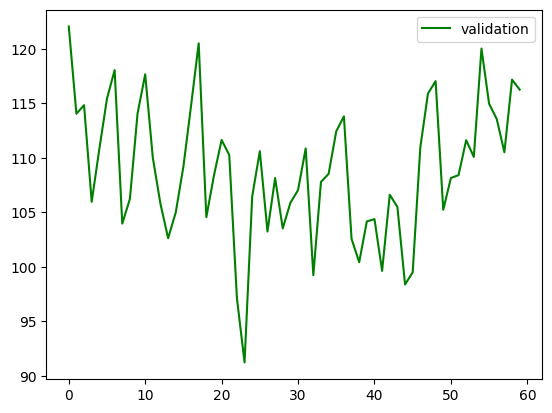

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
cae = CAE().to(device)
optimizer = optim.Adam(cae.parameters(), lr = 1e-3)
train_encoder(criterion, optimizer, cae, x_train_CNN, x_valid_CNN)

In [20]:
## Encoding our data using the auto encoder
with torch.no_grad():
  encoded_x_train = cae.encoder(x_train_CNN.to(device, dtype = torch.float))
  encoded_x_valid = cae.encoder(x_valid_CNN.to(device, dtype = torch.float))
print(encoded_x_train.shape)
print(encoded_x_valid.shape)

torch.Size([6768, 8, 100, 1])
torch.Size([423, 8, 100, 1])


In [21]:
mlp = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_mlp = {
    "x_train": encoded_x_train,
    "y_train": y_train_CNN,
    "x_valid": encoded_x_valid,
    "y_valid": y_valid_CNN
}
training_acc_MLP, validation_acc_MLP = train_model(data_mlp, optimizer, criterion, mlp, batch_size, num_epoch, anneal_=True,  T_mult=1)
start_time = time.time()
test_model(mlp, cae, model_choice="CNN", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Annealing
Current Model:  MLP(
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=800, out_features=400, bias=True)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=200, bias=True)
    (4): ReLU()
    (5): Linear(in_features=200, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=4, bias=True)
  )
)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 2.076
[1, 52] loss: 1.397
[1, 78] loss: 1.322


  2%|▏         | 1/50 [00:00<00:24,  2.02it/s]

[1, 104] loss: 1.303
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.34515365958213806
Epoch:  2
[2, 26] loss: 1.219
[2, 52] loss: 1.163
[2, 78] loss: 1.176


  4%|▍         | 2/50 [00:00<00:23,  2.07it/s]

[2, 104] loss: 1.169
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3617021143436432
Epoch:  3
[3, 26] loss: 1.080
[3, 52] loss: 0.994
[3, 78] loss: 1.040


  6%|▌         | 3/50 [00:01<00:24,  1.95it/s]

[3, 104] loss: 0.989
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3404255211353302
Epoch:  4
[4, 26] loss: 0.853
[4, 52] loss: 0.834
[4, 78] loss: 0.830


  8%|▊         | 4/50 [00:02<00:24,  1.90it/s]

[4, 104] loss: 0.737
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.36643025279045105
Epoch:  5
[5, 26] loss: 0.663
[5, 52] loss: 0.617
[5, 78] loss: 0.653


 10%|█         | 5/50 [00:02<00:23,  1.93it/s]

[5, 104] loss: 0.529
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3640661835670471
Epoch:  6
[6, 26] loss: 0.439
[6, 52] loss: 0.398
[6, 78] loss: 0.383


 12%|█▏        | 6/50 [00:03<00:22,  1.92it/s]

[6, 104] loss: 0.329
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3617021143436432
Epoch:  7
[7, 26] loss: 0.239
[7, 52] loss: 0.227
[7, 78] loss: 0.210


 14%|█▍        | 7/50 [00:03<00:22,  1.92it/s]

[7, 104] loss: 0.165
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3782505989074707
Epoch:  8
[8, 26] loss: 0.145
[8, 52] loss: 0.133
[8, 78] loss: 0.116


 16%|█▌        | 8/50 [00:04<00:20,  2.02it/s]

[8, 104] loss: 0.130
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.35224586725234985
Epoch:  9
[9, 26] loss: 0.091
[9, 52] loss: 0.094
[9, 78] loss: 0.094


 18%|█▊        | 9/50 [00:04<00:19,  2.12it/s]

[9, 104] loss: 0.093
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3569740056991577
Epoch:  10
[10, 26] loss: 0.082
[10, 52] loss: 0.077
[10, 78] loss: 0.086
[10, 104] loss: 0.085
Check:  torch.Size([423, 8, 100, 1])


 20%|██        | 10/50 [00:04<00:18,  2.21it/s]

Validation Accuracy: 0.368794322013855
Reset scheduler after finishing epoch:  10
Epoch:  11
[11, 26] loss: 0.573
[11, 52] loss: 0.714
[11, 78] loss: 0.615
[11, 104] loss: 0.625


 22%|██▏       | 11/50 [00:05<00:17,  2.28it/s]

Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3758865296840668
Epoch:  12
[12, 26] loss: 0.479
[12, 52] loss: 0.455
[12, 78] loss: 0.341


 24%|██▍       | 12/50 [00:05<00:16,  2.26it/s]

[12, 104] loss: 0.281
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.32860520482063293
Epoch:  13
[13, 26] loss: 0.221


 26%|██▌       | 13/50 [00:06<00:16,  2.30it/s]

[13, 52] loss: 0.164
[13, 78] loss: 0.127
[13, 104] loss: 0.167
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.35224586725234985
Epoch:  14
[14, 26] loss: 0.085
[14, 52] loss: 0.081
[14, 78] loss: 0.082


 28%|██▊       | 14/50 [00:06<00:15,  2.30it/s]

[14, 104] loss: 0.072
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3640661835670471
Epoch:  15
[15, 26] loss: 0.030
[15, 52] loss: 0.027
[15, 78] loss: 0.021


 30%|███       | 15/50 [00:07<00:15,  2.28it/s]

[15, 104] loss: 0.020
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.35933807492256165
Epoch:  16
[16, 26] loss: 0.010
[16, 52] loss: 0.009
[16, 78] loss: 0.007


 32%|███▏      | 16/50 [00:07<00:15,  2.26it/s]

[16, 104] loss: 0.006
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.38061466813087463
Epoch:  17
[17, 26] loss: 0.005
[17, 52] loss: 0.004
[17, 78] loss: 0.004


 34%|███▍      | 17/50 [00:08<00:15,  2.16it/s]

[17, 104] loss: 0.004
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3711583912372589
Epoch:  18
[18, 26] loss: 0.003
[18, 52] loss: 0.004
[18, 78] loss: 0.003


 36%|███▌      | 18/50 [00:08<00:15,  2.05it/s]

[18, 104] loss: 0.003
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3758865296840668
Epoch:  19
[19, 26] loss: 0.003
[19, 52] loss: 0.003
[19, 78] loss: 0.003


 38%|███▊      | 19/50 [00:09<00:15,  1.95it/s]

[19, 104] loss: 0.003
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.37352246046066284
Epoch:  20
[20, 26] loss: 0.003
[20, 52] loss: 0.003
[20, 78] loss: 0.003


 40%|████      | 20/50 [00:09<00:15,  1.91it/s]

[20, 104] loss: 0.003
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3711583912372589
Reset scheduler after finishing epoch:  20
Epoch:  21
[21, 26] loss: 0.004
[21, 52] loss: 0.004
[21, 78] loss: 0.012


 42%|████▏     | 21/50 [00:10<00:15,  1.86it/s]

[21, 104] loss: 0.219
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3640661835670471
Epoch:  22
[22, 26] loss: 0.498
[22, 52] loss: 0.498
[22, 78] loss: 0.501


 44%|████▍     | 22/50 [00:10<00:15,  1.84it/s]

[22, 104] loss: 0.347
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.39007091522216797
Epoch:  23
[23, 26] loss: 0.226
[23, 52] loss: 0.155
[23, 78] loss: 0.188


 46%|████▌     | 23/50 [00:11<00:14,  1.84it/s]

[23, 104] loss: 0.203
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.368794322013855
Epoch:  24
[24, 26] loss: 0.094
[24, 52] loss: 0.072
[24, 78] loss: 0.062


 48%|████▊     | 24/50 [00:11<00:14,  1.82it/s]

[24, 104] loss: 0.045
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.35933807492256165
Epoch:  25
[25, 26] loss: 0.019
[25, 52] loss: 0.032
[25, 78] loss: 0.030


 50%|█████     | 25/50 [00:12<00:13,  1.82it/s]

[25, 104] loss: 0.024
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.37352246046066284
Epoch:  26
[26, 26] loss: 0.009
[26, 52] loss: 0.005
[26, 78] loss: 0.004


 52%|█████▏    | 26/50 [00:13<00:13,  1.81it/s]

[26, 104] loss: 0.006
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.347517728805542
Epoch:  27
[27, 26] loss: 0.004
[27, 52] loss: 0.004
[27, 78] loss: 0.003


 54%|█████▍    | 27/50 [00:13<00:13,  1.71it/s]

[27, 104] loss: 0.003
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.35224586725234985
Epoch:  28
[28, 26] loss: 0.002
[28, 52] loss: 0.003
[28, 78] loss: 0.002
[28, 104] loss: 0.002
Check:  torch.Size([423, 8, 100, 1])


 56%|█████▌    | 28/50 [00:14<00:14,  1.56it/s]

Validation Accuracy: 0.3546099364757538
Epoch:  29
[29, 26] loss: 0.002
[29, 52] loss: 0.002
[29, 78] loss: 0.002


 58%|█████▊    | 29/50 [00:15<00:14,  1.43it/s]

[29, 104] loss: 0.002
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3569740056991577
Epoch:  30
[30, 26] loss: 0.002
[30, 52] loss: 0.002


 60%|██████    | 30/50 [00:16<00:14,  1.40it/s]

[30, 78] loss: 0.002
[30, 104] loss: 0.002
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3569740056991577
Reset scheduler after finishing epoch:  30
Epoch:  31
[31, 26] loss: 0.002
[31, 52] loss: 0.002


 62%|██████▏   | 31/50 [00:16<00:13,  1.44it/s]

[31, 78] loss: 0.003
[31, 104] loss: 0.002
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3546099364757538
Epoch:  32
[32, 26] loss: 0.003
[32, 52] loss: 0.002


 64%|██████▍   | 32/50 [00:17<00:12,  1.47it/s]

[32, 78] loss: 0.002
[32, 104] loss: 0.002
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3640661835670471
Epoch:  33
[33, 26] loss: 0.001
[33, 52] loss: 0.001


 66%|██████▌   | 33/50 [00:17<00:11,  1.52it/s]

[33, 78] loss: 0.001
[33, 104] loss: 0.001
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.35224586725234985
Epoch:  34
[34, 26] loss: 0.001
[34, 52] loss: 0.001


 68%|██████▊   | 34/50 [00:18<00:10,  1.51it/s]

[34, 78] loss: 0.001
[34, 104] loss: 0.001
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3498817980289459
Epoch:  35
[35, 26] loss: 0.001
[35, 52] loss: 0.001


 70%|███████   | 35/50 [00:19<00:09,  1.54it/s]

[35, 78] loss: 0.001
[35, 104] loss: 0.001
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.34515365958213806
Epoch:  36
[36, 26] loss: 0.001
[36, 52] loss: 0.001


 72%|███████▏  | 36/50 [00:19<00:08,  1.58it/s]

[36, 78] loss: 0.001
[36, 104] loss: 0.001
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.35224586725234985
Epoch:  37
[37, 26] loss: 0.001
[37, 52] loss: 0.000


 74%|███████▍  | 37/50 [00:20<00:08,  1.60it/s]

[37, 78] loss: 0.000
[37, 104] loss: 0.001
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3498817980289459
Epoch:  38
[38, 26] loss: 0.000
[38, 52] loss: 0.000


 76%|███████▌  | 38/50 [00:21<00:07,  1.62it/s]

[38, 78] loss: 0.000
[38, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.34515365958213806
Epoch:  39
[39, 26] loss: 0.001
[39, 52] loss: 0.000


 78%|███████▊  | 39/50 [00:21<00:06,  1.63it/s]

[39, 78] loss: 0.000
[39, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.347517728805542
Epoch:  40
[40, 26] loss: 0.000
[40, 52] loss: 0.000


 80%|████████  | 40/50 [00:22<00:06,  1.64it/s]

[40, 78] loss: 0.000
[40, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.347517728805542
Reset scheduler after finishing epoch:  40
Epoch:  41
[41, 26] loss: 0.000
[41, 52] loss: 0.001


 82%|████████▏ | 41/50 [00:22<00:05,  1.66it/s]

[41, 78] loss: 0.001
[41, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3498817980289459
Epoch:  42
[42, 26] loss: 0.000
[42, 52] loss: 0.000


 84%|████████▍ | 42/50 [00:23<00:04,  1.68it/s]

[42, 78] loss: 0.000
[42, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.34278959035873413
Epoch:  43
[43, 26] loss: 0.000
[43, 52] loss: 0.000


 86%|████████▌ | 43/50 [00:23<00:04,  1.71it/s]

[43, 78] loss: 0.000
[43, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.34278959035873413
Epoch:  44
[44, 26] loss: 0.000
[44, 52] loss: 0.000


 88%|████████▊ | 44/50 [00:24<00:03,  1.73it/s]

[44, 78] loss: 0.000
[44, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3498817980289459
Epoch:  45
[45, 26] loss: 0.000
[45, 52] loss: 0.000


 90%|█████████ | 45/50 [00:25<00:02,  1.69it/s]

[45, 78] loss: 0.000
[45, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.34278959035873413
Epoch:  46
[46, 26] loss: 0.000
[46, 52] loss: 0.000


 92%|█████████▏| 46/50 [00:25<00:02,  1.67it/s]

[46, 78] loss: 0.000
[46, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.3546099364757538
Epoch:  47
[47, 26] loss: 0.000
[47, 52] loss: 0.000
[47, 78] loss: 0.000
[47, 104] loss: 0.000
Check: 

 94%|█████████▍| 47/50 [00:26<00:01,  1.54it/s]

 torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.34278959035873413
Epoch:  48
[48, 26] loss: 0.000
[48, 52] loss: 0.000
[48, 78] loss: 0.000


 96%|█████████▌| 48/50 [00:27<00:01,  1.51it/s]

[48, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.347517728805542
Epoch:  49
[49, 26] loss: 0.000
[49, 52] loss: 0.000
[49, 78] loss: 0.000


 98%|█████████▊| 49/50 [00:27<00:00,  1.47it/s]

[49, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.34515365958213806
Epoch:  50
[50, 26] loss: 0.000
[50, 52] loss: 0.000
[50, 78] loss: 0.000


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]

[50, 104] loss: 0.000
Check:  torch.Size([423, 8, 100, 1])
Validation Accuracy: 0.34515365958213806
Reset scheduler after finishing epoch:  50
Finish Training


Test accuracy for  MLP + Autoencoder is:  0.38826185101580135
Time To Run:  0.3022456169128418 seconds
